In [1]:
#importing all modules and packages used

import petroeval as pet
import lasio as las
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn import preprocessing
import lightgbm as lgb
import catboost as cat

%matplotlib inline

In [2]:
class Model():
    
    def __init__(self, model, train, test, train_label, test_label):
        
        self.model = model
        self.train = train
        self.test = test
        self.train_label = train_label
        self.test_label = test_label
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
        
        cols = ['GR', 'NPHI', 'RHOB', 'RT']
        #using StandardScaler function to scale the numeric features 

        scaler = preprocessing.StandardScaler().fit(self.train)
        self.train = scaler.transform(self.train)
        self.train = pd.DataFrame(self.train, columns=cols)
        
        #using StandardScaler function to scale the numeric features 


        self.test = scaler.transform(self.test)
        self.test = pd.DataFrame(self.test, columns=cols)

        
        #SPLIT ONE

        self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   self.train_label, 
                                                                                   test_size=0.25, random_state=42)

            #SPLIT TWO

        self.x_test1, self.x_test2, self.y_test1, self.y_test2 = ms.train_test_split(self.x_test,
                                                                                     self.y_test,
                                                                                     test_size=0.5,
                                                                                     random_state=42)

        rf = RandomForestRegressor(n_estimators=400, max_depth=None, max_features="auto",min_samples_split=2, min_samples_leaf=1, verbose=20)
        
        ext = ExtraTreesRegressor(n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', verbose=20)
        
        dtr = DecisionTreeRegressor(max_depth=None, max_features='auto', min_samples_leaf=1, min_impurity_split=2)

        def show_evaluation(pred, true):

            print(f'RMSE: {mean_squared_error(true.values, pred)**0.5}')
            print(f'R1 Score is: {r2_score(true, pred)}')
            #print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
            
        if self.model == 'dtr':
            self.model = dtr
        elif self.model == 'ext':
            self.model = ext
        else:
            self.model = rf
            
        split=10
        kf = KFold(n_splits=split, shuffle=False)
        pred_test = np.zeros((len(self.x_test)))
        open_test_pred = np.zeros((len(self.test)))
        
        for (train_index, test_index) in kf.split(pd.DataFrame(self.train), pd.DataFrame(self.train_label)):
            #X_train,X_test = pd.DataFrame(self.train).iloc[train_index], pd.DataFrame(self.train).iloc[test_index]
            #y_train,y_test = pd.DataFrame(self.train_label).iloc[train_index], pd.DataFrame(self.train_label).iloc[test_index]
            self.model.fit(pd.DataFrame(self.train, columns=list(self.train.columns)),self.train_label)
            #scores.append(metric(model.predict_proba(X_test),y_test))
            pred_test+=self.model.predict(self.x_test)
           # pred_val+=self.model.predict_proba(self.x_test2)
            open_test_pred+=self.model.predict(self.test)
            
        test_result = (pred_test/split)
        open_result = (open_test_pred/split)


        

        print('----------------TEST EVALUATION------------------')
        show_evaluation(test_result, self.y_test)
        
        print('----------------REAL TEST EVALUATION------------------')
        show_evaluation(open_result, self.test_label)

        
        if plot: self.plot_feat_imp(self.model)
        return open_result, self.model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [3]:
def show_plots(actual_data, predicted_log):

    new_log = pd.DataFrame()
    new_log['Actual'] = actual_data.DT
    new_log['Predicted'] = predicted_log

    pet.two_plots(new_log, 'Actual', 'Predicted', 0, len(new_log.index))

In [4]:
def final_plots(actual_data, predicted_logs):
    
    new_log = pd.DataFrame()
    new_log['Actual'] = actual_data.DT
    new_log['DTR'] = predicted_logs[0]
    new_log['ETR'] = predicted_logs[1]
    new_log['RF'] = predicted_logs[2]
    
    pet.four_plots(new_log, 'Actual', 'DTR', 'ETR', 'RF', 0, len(new_log.index))

In [7]:

def log_plot1(logs):
    #logs = logs.sort_values(by='index')
    top = logs.index.min()
    bot = logs.index.max()
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,8))
    ax[0].plot(logs.DT, logs.index, color='red')
    ax[1].plot(logs.GR, logs.index, color='black')
    ax[2].plot(logs.NPHI, logs.index, color='blue')
    ax[3].plot(logs.RHOB, logs.index, color='c')
    ax[4].plot(logs.RT, logs.index, color='m')
    
    for i in range(len(ax)):
        ax[i].set_ylim(top,bot)
        ax[i].invert_yaxis()
        ax[i].grid()
        
    ax[0].set_xlabel("DT (us/ft)")
    ax[0].set_xlim(logs.DT.min(), logs.DT.max())
    ax[0].set_ylabel("Depth(ft)")
    ax[1].set_xlabel("GR (API)")
    ax[1].set_xlim(logs.GR.min(), logs.GR.max())
    ax[2].set_xlabel("NPHI (v/v)")
    ax[2].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    ax[3].set_xlabel("RHOB (g/cm3)")
    ax[3].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[4].set_xlabel("RT (ohm.m)")
    ax[4].set_xscale("log")
    ax[4].set_xlim(-2,logs.RT.max())
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]);
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[4].set_yticklabels([]) 
    
    f.suptitle('Well: 15-9-F-11', fontsize=14,y=0.94)

# EXPLORATORY DATA ANALYSIS

In [3]:
F1 = pet.read_lasio('./15_9-F-1/WLC_PETRO_COMPUTED_INPUT_1.LAS')
F11A = pet.read_lasio('./15_9-F-11 A/WLC_PETRO_COMPUTED_INPUT_1.LAS')
F11B = pet.read_lasio('./15_9-F-11 B/WLC_PETRO_COMPUTED_INPUT_1.LAS')
F11T2 = pet.read_lasio('./15_9-F-11 T2/WLC_PETRO_COMPUTED_INPUT_1.LAS')
F12 = pet.read_lasio('./15_9-F-12/WLC_PETRO_COMPUTED_INPUT_1.LAS')
F15D = pet.read_lasio('./15_9-F-15 D/WLC_PETRO_COMPUTED_INPUT_1.LAS')

F1, F11A, F11B, F11T2, F12, F15D

Header section Parameter regexp=~P was not found.


(<lasio.las.LASFile at 0x7f4629894fd0>,
 <lasio.las.LASFile at 0x7f4629838550>)

In [4]:
F1 = F1.df()
F1.head()

ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO  DT  GR  NPHI  \
DEPTH                                                                           
145.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN NaN   NaN   
146.0       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN NaN   NaN   
146.1       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN NaN   NaN   
146.2       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN NaN   NaN   
146.3       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN NaN   NaN   

       PEF  RACEHM  RACELM  RD  RHOB  RM  ROP  RPCEHM  RPCELM  RT  
DEPTH                                                              
145.9  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
146.0  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
146.1  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
146.2  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
146.3  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN

In [5]:
F11A = F11A.df()
F11A.head()

ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO  DT  DTS  \
DEPTH                                                                      
188.5       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
188.6       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
188.7       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
188.8       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
188.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   

          GR  ...  PEF  RACEHM  RACELM  RD  RHOB  RM  ROP  RPCEHM  RPCELM  RT  
DEPTH         ...                                                              
188.5  4.300  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.6  3.801  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.7  4.301  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.8  4.600  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.9  4.599  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  

[5 rows x 21 columns]

In [6]:
F11B = F11B.df()
F11B.head()

ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO     GR  NPHI  \
DEPTH                                                                          
188.5       NaN       NaN       NaN       NaN  36.0   NaN   NaN  4.300   NaN   
188.6       NaN       NaN       NaN       NaN  36.0   NaN   NaN  3.801   NaN   
188.7       NaN       NaN       NaN       NaN  36.0   NaN   NaN  4.301   NaN   
188.8       NaN       NaN       NaN       NaN  36.0   NaN   NaN  4.600   NaN   
188.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN  4.599   NaN   

       PEF  RACEHM  RACELM  RD  RHOB  RM  ROP  RPCEHM  RPCELM  RT  
DEPTH                                                              
188.5  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.6  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.7  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.8  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.9  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN

In [7]:
F11T2 = F11T2.df()
F11T2.head()

ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO  DT  DTS   GR  \
DEPTH                                                                           
188.5       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN  4.3   
188.6       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN  3.8   
188.7       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN  4.3   
188.8       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN  4.6   
188.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN  4.6   

       ...  PEF  RACEHM  RACELM  RD  RHOB  RM  ROP  RPCEHM  RPCELM  RT  
DEPTH  ...                                                              
188.5  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.6  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.7  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.8  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
188.9  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  

[5 rows x 21 columns]

In [8]:
F12 = F12.df()
F12.head()

CARB_FLAG  COAL_FLAG  DT         GR  NPHI      RD  RHOB    ROP5_RM  \
DEPTH                                                                          
239.8776        NaN        NaN NaN        NaN   NaN  0.7766   NaN  98.863197   
240.0300        NaN        NaN NaN        NaN   NaN  0.7717   NaN  98.687103   
240.1824        NaN        NaN NaN        NaN   NaN  0.7717   NaN  99.039299   
240.3348        NaN        NaN NaN  20.866899   NaN  0.4374   NaN  99.760498   
240.4872        NaN        NaN NaN  20.984800   NaN  2.3402   NaN  99.748299   

                  RS      RT  SAND_FLAG  
DEPTH                                    
239.8776    4.490900  0.1015        NaN  
240.0300    6.752500  0.1000        NaN  
240.1824    6.752500  0.1000        NaN  
240.3348   12.005200  0.1000        NaN  
240.4872  139.059204  0.1000        NaN

In [9]:
F15D = F15D.df()
F15D.head()

ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO  GR  NBGRCFM  \
DEPTH                                                                          
145.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN      NaN   
146.0       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN      NaN   
146.1       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN      NaN   
146.2       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN      NaN   
146.3       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN      NaN   

       NPHI  PEF  RACEHM  RACELM  RD  RHOB  RM  ROP  RPCEHM  RPCELM  RT  
DEPTH                                                                    
145.9   NaN  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
146.0   NaN  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
146.1   NaN  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
146.2   NaN  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
146.3   NaN  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN

In [10]:
F1.shape, F11A.shape, F11B.shape, F11T2.shape, F12.shape, F15D.shape

((34861, 20), (35735, 21), (45818, 19), (43733, 21), (25899, 11), (45391, 20))

In [11]:
logs_list = [F1, F11A, F11B, F11T2, F12, F15D]

In [12]:
for log in logs_list:
    print(f'-------------_______-----------------------------------------____________------------')
    print(log.isna().sum())

-------------_______-----------------------------------------____________------------
ABDCQF01    25185
ABDCQF02    25185
ABDCQF03    25185
ABDCQF04    25185
BS              0
CALI        24726
DRHO        24719
DT          25039
GR            692
NPHI        24843
PEF         24392
RACEHM       1051
RACELM       1051
RD           1152
RHOB        24815
RM           1152
ROP           806
RPCEHM       1051
RPCELM       1051
RT           1051
dtype: int64
-------------_______-----------------------------------------____________------------
ABDCQF01    23267
ABDCQF02    23402
ABDCQF03    23839
ABDCQF04    23410
BS              0
CALI        24054
DRHO        24047
DT          24260
DTS         24651
GR            144
NPHI        24138
PEF         24110
RACEHM      23857
RACELM      23857
RD            570
RHOB        24110
RM            570
ROP           386
RPCEHM      23909
RPCELM      23891
RT            570
dtype: int64
-------------_______-----------------------------------------___

In [13]:
for log in logs_list:
    print(f'-------------_______-----------------------------------------____________------------')
    print(log.describe())

-------------_______-----------------------------------------____________------------
          ABDCQF01     ABDCQF02     ABDCQF03     ABDCQF04            BS  \
count  9676.000000  9676.000000  9676.000000  9676.000000  34861.000000   
mean      2.486954     2.490317     2.492418     2.489801     18.021957   
std       0.131763     0.133055     0.134572     0.133050      7.407961   
min       1.689400     1.711800     1.818800     1.744000      8.500000   
25%       2.442400     2.447375     2.449450     2.444700      8.500000   
50%       2.535150     2.539150     2.541400     2.538400     17.500000   
75%       2.576000     2.581625     2.584300     2.581525     26.000000   
max       2.924100     2.751100     2.862200     2.919000     36.000000   

               CALI          DRHO           DT            GR          NPHI  \
count  10135.000000  10142.000000  9822.000000  34169.000000  10018.000000   
mean       8.588488      0.051502    77.410579     58.717495      0.169421   
std 

           ABDCQF01      ABDCQF02      ABDCQF03      ABDCQF04            BS  \
count  19369.000000  19369.000000  19369.000000  19369.000000  43733.000000   
mean       2.495900      2.502245      2.502557      2.498966     15.740470   
std        0.128024      0.130497      0.131405      0.128957      7.373113   
min        1.921000      1.961000      2.067000      2.074000      8.500000   
25%        2.459000      2.468000      2.467000      2.464000      8.500000   
50%        2.529000      2.535000      2.536000      2.532000     17.500000   
75%        2.583000      2.590000      2.591000      2.585000     26.000000   
max        3.022000      3.026000      3.042000      3.142000     36.000000   

               CALI          DRHO            DT           DTS            GR  \
count  19677.000000  19683.000000  19465.000000  18721.000000  43566.000000   
mean       8.684985      0.059024     75.507783    138.132721     48.779702   
std        0.060765      0.010430     14.913084    

# Data Prepration and Visualization

The missing values were cut off from each well to focus on the availaable region since that is what will be used in preparing the training datasets

In [14]:
F1.tail()

ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04   BS  CALI  DRHO  DT  GR  NPHI  \
DEPTH                                                                           
3631.5       NaN       NaN       NaN       NaN  8.5   NaN   NaN NaN NaN   NaN   
3631.6       NaN       NaN       NaN       NaN  8.5   NaN   NaN NaN NaN   NaN   
3631.7       NaN       NaN       NaN       NaN  8.5   NaN   NaN NaN NaN   NaN   
3631.8       NaN       NaN       NaN       NaN  8.5   NaN   NaN NaN NaN   NaN   
3631.9       NaN       NaN       NaN       NaN  8.5   NaN   NaN NaN NaN   NaN   

        PEF  RACEHM  RACELM  RD  RHOB  RM      ROP  RPCEHM  RPCELM  RT  
DEPTH                                                                   
3631.5  NaN     NaN     NaN NaN   NaN NaN  15.0631     NaN     NaN NaN  
3631.6  NaN     NaN     NaN NaN   NaN NaN  15.0356     NaN     NaN NaN  
3631.7  NaN     NaN     NaN NaN   NaN NaN  15.0080     NaN     NaN NaN  
3631.8  NaN     NaN     NaN NaN   NaN NaN  14.9805     NaN     NaN NaN  
3631.9  NaN     NaN     NaN NaN   NaN NaN  15.0032     NaN     NaN NaN

In [12]:
f1 = pd.DataFrame()
f1['DT'] = F1.DT
f1['GR'] = F1.GR
f1['NPHI'] = F1.NPHI
f1['RHOB'] = F1.RHOB
f1['RT'] = F1.RT
f1.index = F1.index

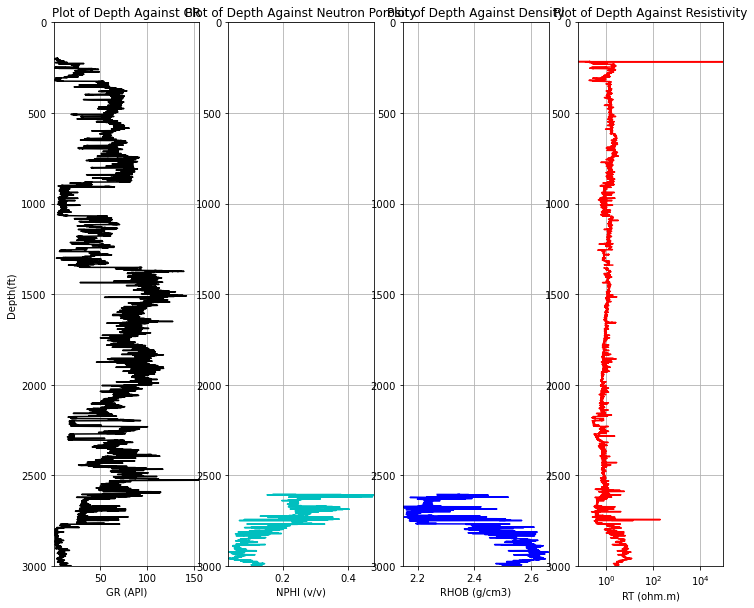

In [13]:
pet.log_plot(f1, top=0, base=3000)

In [14]:
f11A = pd.DataFrame()
f11A['DT'] = F11A.DT
f11A['GR'] = F11A.GR
f11A['NPHI'] = F11A.NPHI
f11A['RHOB'] = F11A.RHOB
f11A['RT'] = F11A.RT
f11A.index = F11A.index

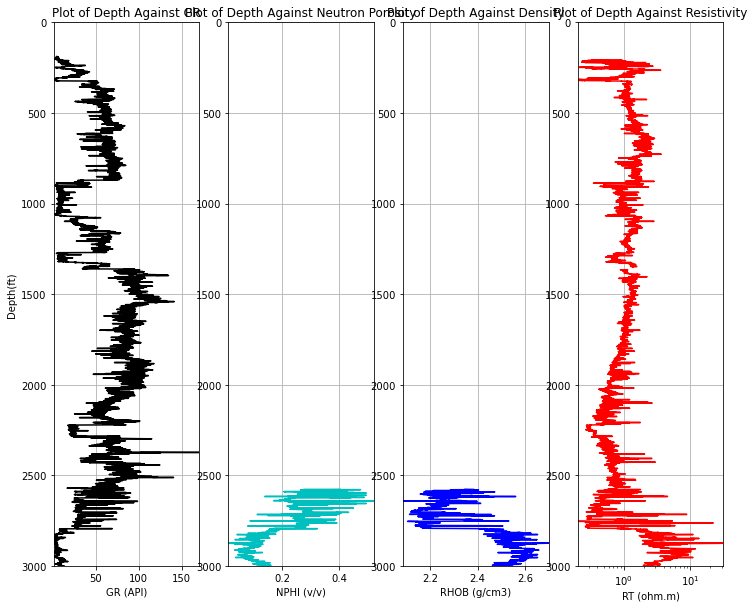

In [15]:
pet.log_plot(f11A, top=0, base=3000)

In [16]:
f11B = pd.DataFrame()
#f11B['DT'] = F11B.DT
f11B['GR'] = F11B.GR
f11B['NPHI'] = F11B.NPHI
f11B['RHOB'] = F11B.RHOB
f11B['RT'] = F11B.RT
f11B.index = F11B.index

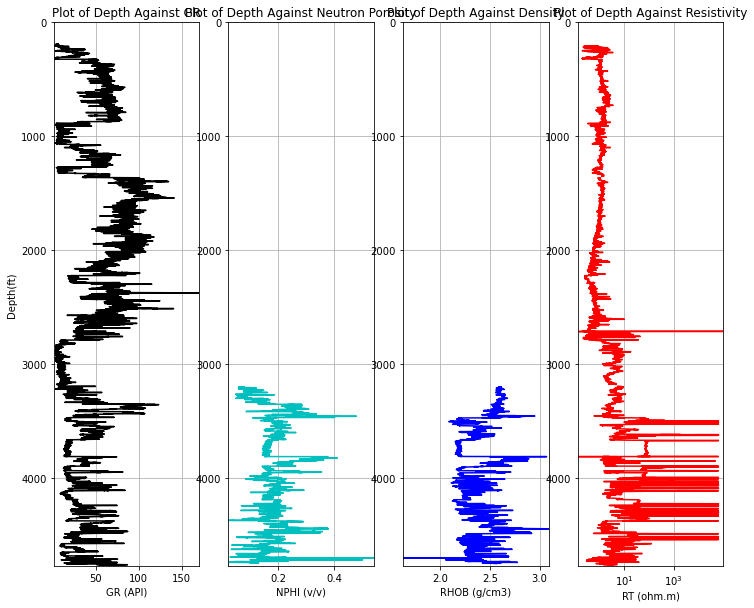

In [17]:
pet.log_plot(F11B, 0, 4770)

In [21]:
f15D.tail()

GR  NPHI  RHOB  RT   DEPTH
DEPTH                             
4684.5 NaN   NaN   NaN NaN  4684.5
4684.6 NaN   NaN   NaN NaN  4684.6
4684.7 NaN   NaN   NaN NaN  4684.7
4684.8 NaN   NaN   NaN NaN  4684.8
4684.9 NaN   NaN   NaN NaN  4684.9

In [22]:
f11T2 = pd.DataFrame()
f11T2['DT'] = F11T2.DT
f11T2['GR'] = F11T2.GR
f11T2['NPHI'] = F11T2.NPHI
f11T2['RHOB'] = F11T2.RHOB
f11T2['RT'] = F11T2.RT
f11T2.index = F11T2.index

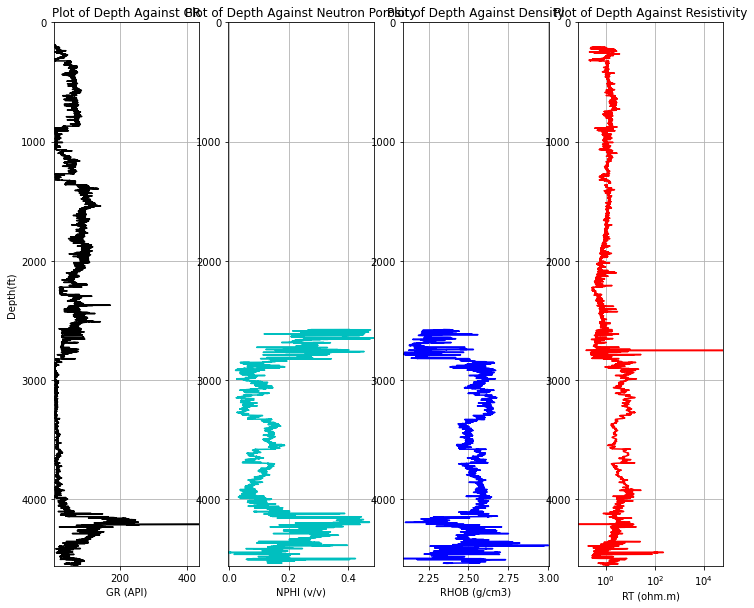

In [23]:
pet.log_plot(f11T2, 0, 4561)

In [24]:
f12 = pd.DataFrame()
f12['DT'] = F12.DT
f12['GR'] = F12.GR
f12['NPHI'] = F12.NPHI
f12['RHOB'] = F12.RHOB
f12['RT'] = F12.RT
f12.index = F12.index

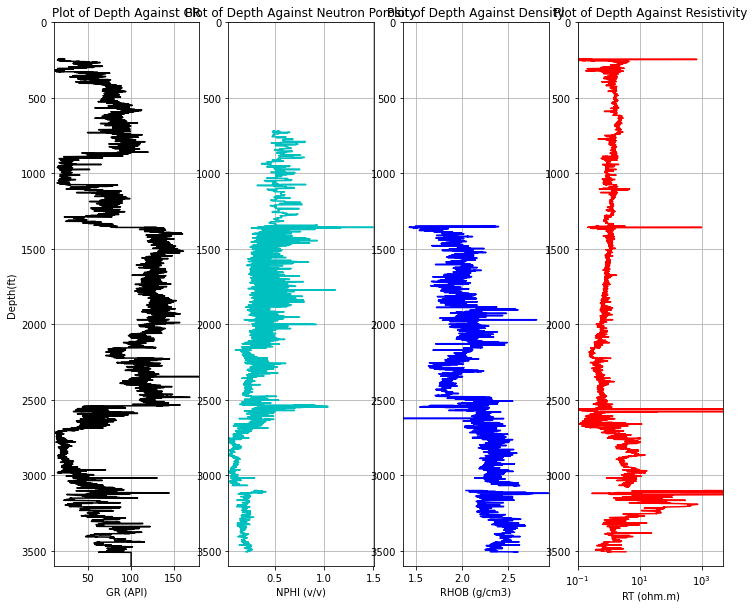

In [25]:
pet.log_plot(f12, 0, 3600)

In [26]:
f15D = pd.DataFrame()
#f15D['DT'] = F15D.DT
f15D['GR'] = F15D.GR
f15D['NPHI'] = F15D.NPHI
f15D['RHOB'] = F15D.RHOB
f15D['RT'] = F15D.RT
f15D.index = F15D.index

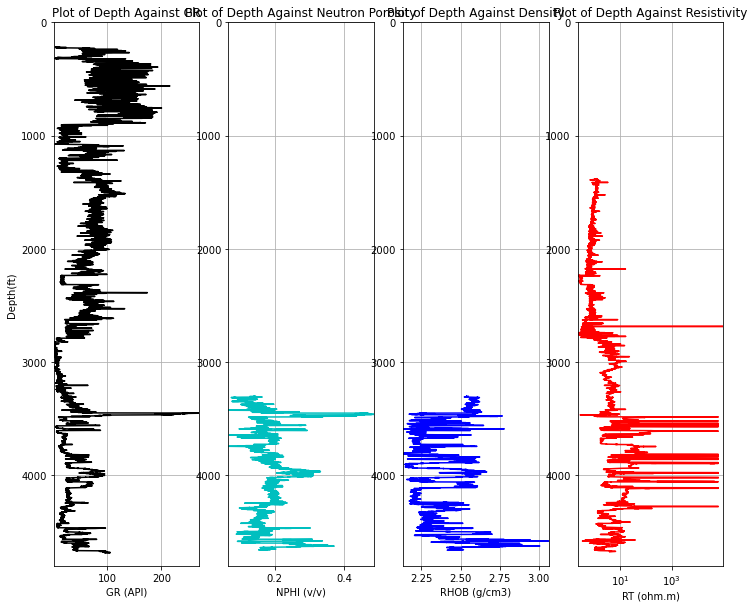

In [27]:
pet.log_plot(f15D, 0, 4800)

In [28]:
f1_edited = f1.dropna()
f1_edited.tail()

DT       GR    NPHI    RHOB      RT   DEPTH
DEPTH                                                   
3598.5  76.6795  90.2940  0.1634  2.5984  2.1991  3598.5
3598.6  76.3281  85.8942  0.1686  2.5997  2.2756  3598.6
3598.7  76.0730  83.1276  0.1811  2.5998  2.3320  3598.7
3598.8  75.9054  81.5331  0.1977  2.5984  2.3674  3598.8
3598.9  75.9105  83.8768  0.2117  2.5959  2.2720  3598.9

/home/olawale/anaconda3/lib/python3.7/site-packages/petroeval/plots.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['DEPTH'] = logs.index


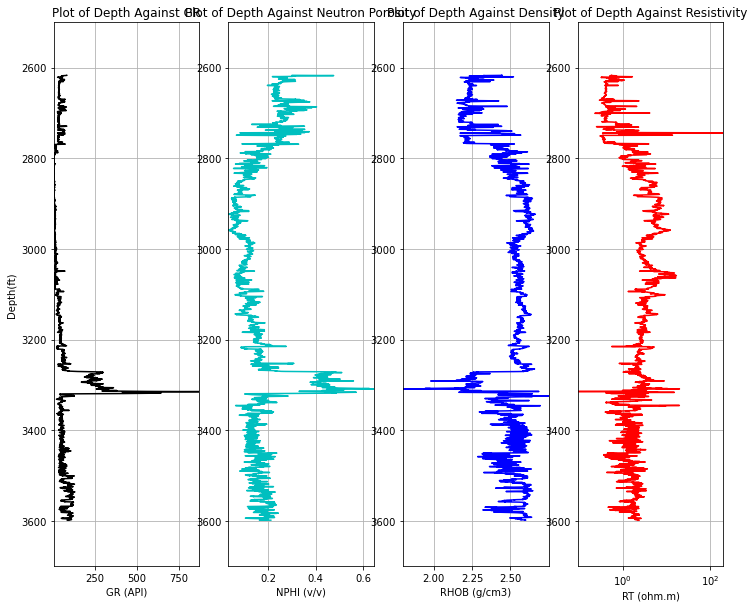

In [29]:
pet.log_plot(f1_edited, 2500, 3700)

In [30]:
f11A_edited = f11A.dropna()
f11A_edited.tail()

DT      GR   NPHI   RHOB     RT   DEPTH
DEPTH                                              
3722.9  83.399  68.077  0.188  2.438  0.982  3722.9
3723.0  83.763  68.856  0.182  2.434  1.020  3723.0
3723.1  84.560  70.850  0.182  2.432  1.054  3723.1
3723.2  84.867  69.909  0.184  2.431  1.045  3723.2
3723.3  84.934  68.948  0.187  2.434  1.014  3723.3

/home/olawale/anaconda3/lib/python3.7/site-packages/petroeval/plots.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['DEPTH'] = logs.index


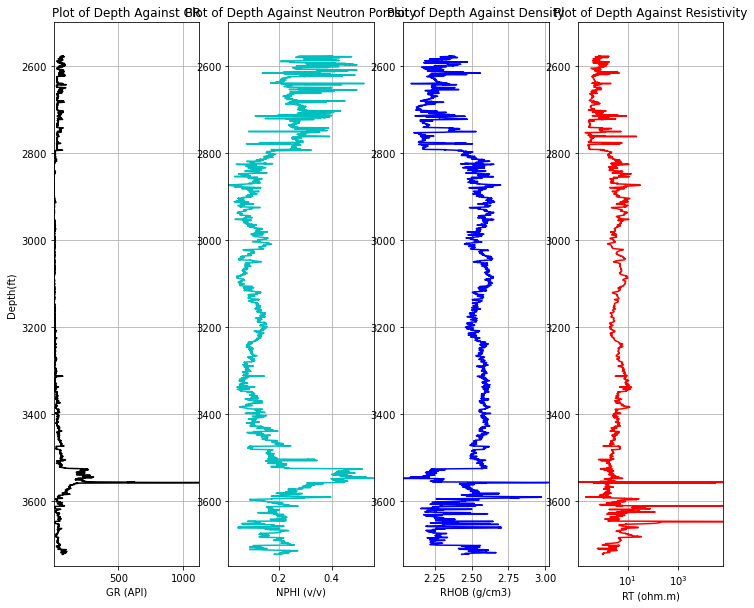

In [33]:
pet.log_plot(f11A_edited, 2500, 3750)

In [34]:
f11B_edited = f11B.dropna()
f11B_edited.tail()

GR   NPHI   RHOB     RT
DEPTH                              
4744.3  16.249  0.115  2.447  1.809
4744.4  18.881  0.118  2.446  1.487
4744.5  20.047  0.121  2.441  1.208
4744.6  22.520  0.120  2.438  1.137
4744.7  25.265  0.125  2.440  1.093

/home/olawale/anaconda3/lib/python3.7/site-packages/petroeval/plots.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['DEPTH'] = logs.index


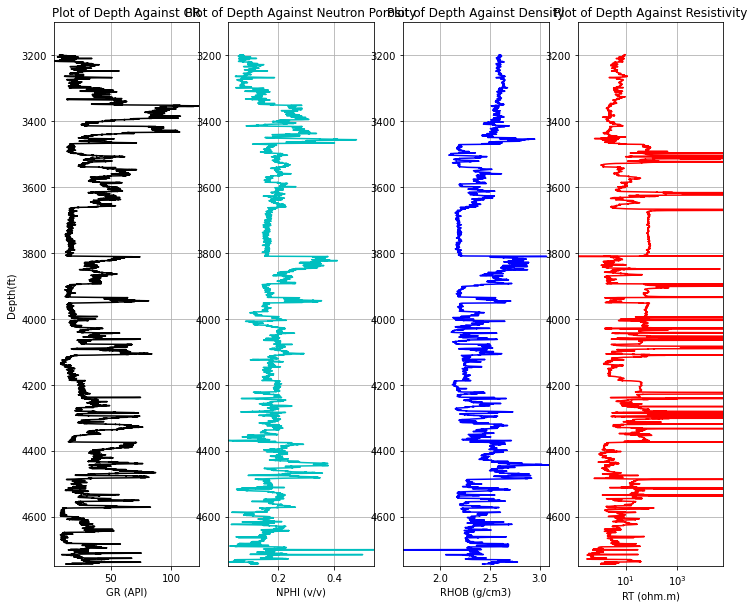

In [37]:
pet.log_plot(f11B_edited, 3100, 4750)

In [38]:
f11T2_edited = f11T2.dropna()
f11T2_edited.tail()

DT      GR   NPHI   RHOB     RT   DEPTH
DEPTH                                              
4521.9  73.536  83.937  0.185  2.461  1.863  4521.9
4522.0  71.441  85.725  0.181  2.459  1.834  4522.0
4522.1  69.882  86.486  0.174  2.458  1.812  4522.1
4522.2  68.713  83.485  0.162  2.458  1.869  4522.2
4522.3  68.127  81.584  0.149  2.464  2.020  4522.3

/home/olawale/anaconda3/lib/python3.7/site-packages/petroeval/plots.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['DEPTH'] = logs.index


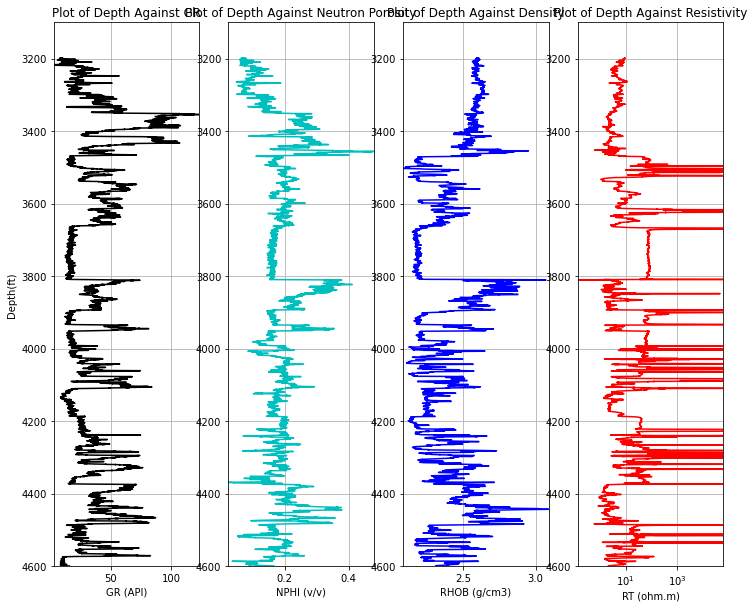

In [39]:
pet.log_plot(f11B_edited, 3100, 4600)

In [50]:
f12_edited = f12.dropna()
f12_edited.tail()

DT         GR    NPHI    RHOB      RT      DEPTH
DEPTH                                                             
3441.9540  86.421097  69.547798  0.2125  2.3700  0.7082  3441.9540
3442.1064  91.530403  68.673103  0.2099  2.3679  0.7164  3442.1064
3442.2588  81.688400  68.032997  0.2090  2.3648  0.7255  3442.2588
3442.4112  78.252502  67.392998  0.2081  2.3618  0.7347  3442.4112
3442.5636  78.339203  66.768097  0.2074  2.3613  0.7514  3442.5636

/home/olawale/anaconda3/lib/python3.7/site-packages/petroeval/plots.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['DEPTH'] = logs.index


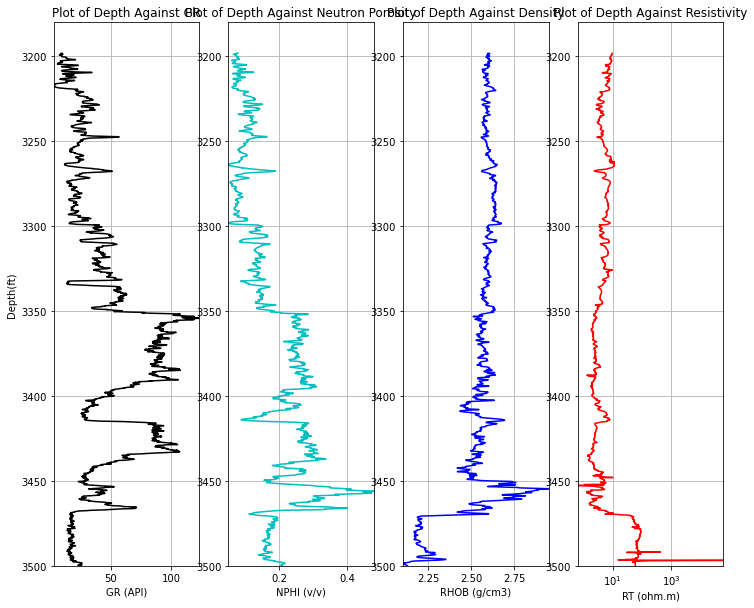

In [43]:
pet.log_plot(f11B_edited, 3180, 3500)

In [44]:
f15D_edited = f15D.dropna()
f15D_edited.tail()

GR    NPHI    RHOB      RT   DEPTH
DEPTH                                          
4658.0  43.0931  0.1573  2.4374  1.0742  4658.0
4658.1  43.2569  0.1560  2.4381  1.0781  4658.1
4658.2  43.8828  0.1550  2.4381  1.0860  4658.2
4658.3  44.1790  0.1551  2.4374  1.0930  4658.3
4658.4  43.5732  0.1556  2.4353  1.0909  4658.4

/home/olawale/anaconda3/lib/python3.7/site-packages/petroeval/plots.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['DEPTH'] = logs.index


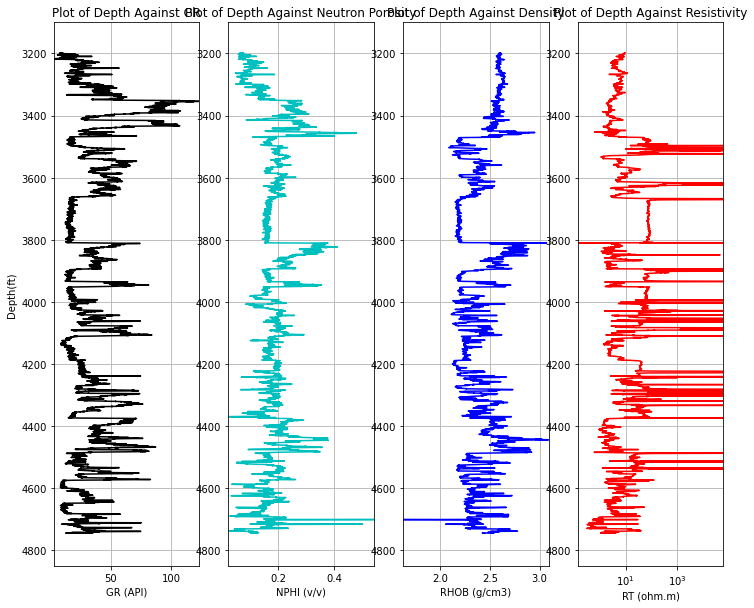

In [48]:
pet.log_plot(f11B_edited, 3100, 4850)

In [52]:
f1_edited.to_csv('f1_edited.csv')   #train & validation
f15D_edited.to_csv('f15D_edited.csv')   #test
f11B_edited.to_csv('f11B_edited.csv')   #test
f11A_edited.to_csv('f11A_edited.csv')    #train & validation
f11T2_edited.to_csv('f11T2_edited.csv')    #train & validation
f12_edited.to_csv('f12_edited.csv')     #train & validation

In [5]:
f1_edited = pd.read_csv('f1_edited.csv')
f15D_edited = pd.read_csv('f15D_edited.csv')
f11B_edited = pd.read_csv('f11B_edited.csv')
f11A_edited = pd.read_csv('f11A_edited.csv')
f11T2_edited = pd.read_csv('f11T2_edited.csv')
f12_edited = pd.read_csv('f12_edited.csv')

In [6]:
f1_valid = pd.read_csv('f1_valid.csv')
f11a_valid = pd.read_csv('f11a_valid.csv')
ft2_valid = pd.read_csv('ft2_valid.csv')
f12_valid = pd.read_csv('f12_valid.csv')
f1_valid.dropna(inplace=True)
f11a_valid.dropna(inplace=True)
ft2_valid.dropna(inplace=True)
f12_valid.dropna(inplace=True)

In [7]:
f1 = f1_edited
f15 = f15D_edited
f11b = f11B_edited
f11a = f11A_edited
ft2 = f11T2_edited
f12 = f12_edited

In [9]:
f1.shape, f15.shape, f11b.shape, f11a.shape, ft2.shape, f12.shape

((9822, 7), (13566, 6), (15466, 6), (11464, 7), (19433, 7), (12860, 7))

# Creating Train, Test and Validation Datasets

Training Dataset while f1 is used for validation

In [66]:
f11a

DEPTH       DT      GR   NPHI   RHOB     RT  DEPTH.1
0      2577.0  109.385  74.697  0.403  2.347  0.751   2577.0
1      2577.1  110.132  72.797  0.399  2.357  0.798   2577.1
2      2577.2  110.843  71.629  0.390  2.360  0.750   2577.2
3      2577.3  111.010  69.899  0.385  2.361  0.719   2577.3
4      2577.4  110.797  69.041  0.382  2.363  0.693   2577.4
...       ...      ...     ...    ...    ...    ...      ...
11459  3722.9   83.399  68.077  0.188  2.438  0.982   3722.9
11460  3723.0   83.763  68.856  0.182  2.434  1.020   3723.0
11461  3723.1   84.560  70.850  0.182  2.432  1.054   3723.1
11462  3723.2   84.867  69.909  0.184  2.431  1.045   3723.2
11463  3723.3   84.934  68.948  0.187  2.434  1.014   3723.3

[11464 rows x 7 columns]

In [67]:
test

GR   NPHI   RHOB     RT  DEPTH.1
0      74.697  0.403  2.347  0.751   2577.0
1      72.797  0.399  2.357  0.798   2577.1
2      71.629  0.390  2.360  0.750   2577.2
3      69.899  0.385  2.361  0.719   2577.3
4      69.041  0.382  2.363  0.693   2577.4
...       ...    ...    ...    ...      ...
11459  68.077  0.188  2.438  0.982   3722.9
11460  68.856  0.182  2.434  1.020   3723.0
11461  70.850  0.182  2.432  1.054   3723.1
11462  69.909  0.184  2.431  1.045   3723.2
11463  68.948  0.187  2.434  1.014   3723.3

[11464 rows x 5 columns]

# Training and Validation

Training and validation using wel F11A

In [19]:
train_label = f11a_valid['DT']
test_label = f11a['DT']
train = f11a_valid.drop('DT', axis=1)
test = f11a.drop('DT', axis=1)
train.drop('DEPTH', axis=1, inplace=True)
test.drop('DEPTH', axis=1, inplace=True)
#train.drop('DEPTH.1', axis=1, inplace=True)
test.drop('DEPTH.1', axis=1, inplace=True)

In [69]:
train.head()

GR    NPHI    RHOB      RT
0  79.8456  0.3023  2.4445  0.5524
1  79.6564  0.3483  2.4468  0.5399
2  78.1091  0.4028  2.4213  0.5376
3  76.7843  0.4428  2.3815  0.5353
4  73.6875  0.4643  2.3464  0.5362

In [70]:
test.head()

GR   NPHI   RHOB     RT
0  74.697  0.403  2.347  0.751
1  72.797  0.399  2.357  0.798
2  71.629  0.390  2.360  0.750
3  69.899  0.385  2.361  0.719
4  69.041  0.382  2.363  0.693

In [62]:
f11a.head()

DEPTH       DT      GR   NPHI   RHOB     RT  DEPTH.1
0  2577.0  109.385  74.697  0.403  2.347  0.751   2577.0
1  2577.1  110.132  72.797  0.399  2.357  0.798   2577.1
2  2577.2  110.843  71.629  0.390  2.360  0.750   2577.2
3  2577.3  111.010  69.899  0.385  2.361  0.719   2577.3
4  2577.4  110.797  69.041  0.382  2.363  0.693   2577.4

Random Forest

In [44]:
open_pred

array([135.38495605, 135.38495605, 135.38495605, ...,  81.81568554,
        84.85843686,  88.02343315])

In [45]:
test_label

0        99.8262
1        99.9305
2       100.1234
3       100.2931
4       100.3768
          ...   
9817     76.6795
9818     76.3281
9819     76.0730
9820     75.9054
9821     75.9105
Name: DT, Length: 9822, dtype: float64

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.8s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.3s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.5s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.9s remaining:    0.0s


building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.3s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.7s remaining:    0.0s


building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.9s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.8s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.2s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.5s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.9s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.7s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.2s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.6s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.9s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.3s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.5s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.9s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.8s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.1s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.5s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.9s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.1s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.5s remaining:    0.0s


building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.7s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.5s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.8s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.2s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.6s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.8s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.0s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.2s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.4s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.7s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.9s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.9s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.3s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.7s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.2s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.6s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.8s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.0s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.9s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.3s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.5s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.8s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.2s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.4s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.6s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.0s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.6s remaining:    0.0s


building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.8s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.2s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.5s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s remaining:    0.0s


building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.1s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.6s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.4s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.7s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.9s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.1s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.5s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.9s remaining:    0.0s


building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.1s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.4s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.6s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    2.8s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.2s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.4s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.8s remaining:    0.0s


building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.1s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

----------------TEST EVALUATION------------------
RMSE: 1.067327926540541
R1 Score is: 0.9982164831131217
----------------REAL TEST EVALUATION------------------
RMSE: 7.213217993984125
R1 Score is: 0.7847999779048996


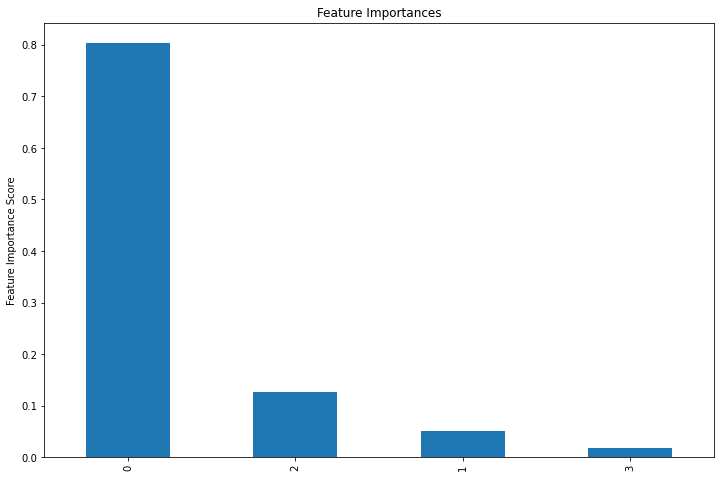

In [20]:
func_= Model('rf', train, test, train_label, test_label)
open_pred_rf, model = func_()
#make_submission(open_pred, filename='CATBOOST1-(UNKNOWN1)')

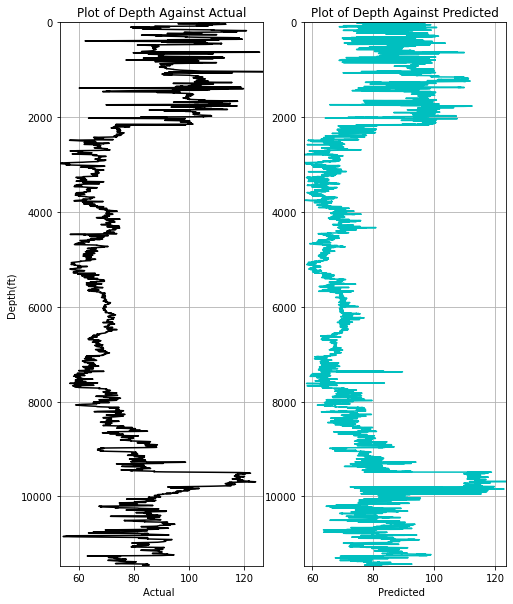

In [21]:
show_plots(f11a, open_pred_rf)

/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: Fut

----------------TEST EVALUATION------------------
RMSE: 1.0144030063037766
R1 Score is: 0.9983889740526466
----------------REAL TEST EVALUATION------------------
RMSE: 8.591967718835724
R1 Score is: 0.6946700053592305


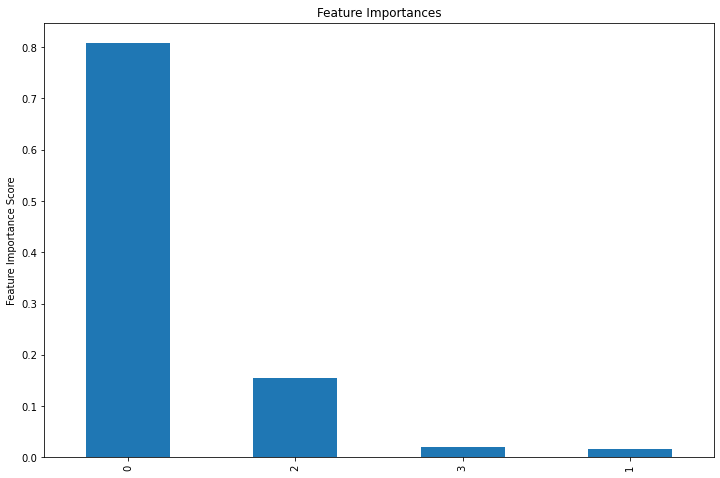

In [22]:
func_= Model('dtr', train, test, train_label, test_label)
open_pred_dtr, model = func_()
#make_submission(open_pred, filename='CATBOOST1-(UNKNOWN1)')

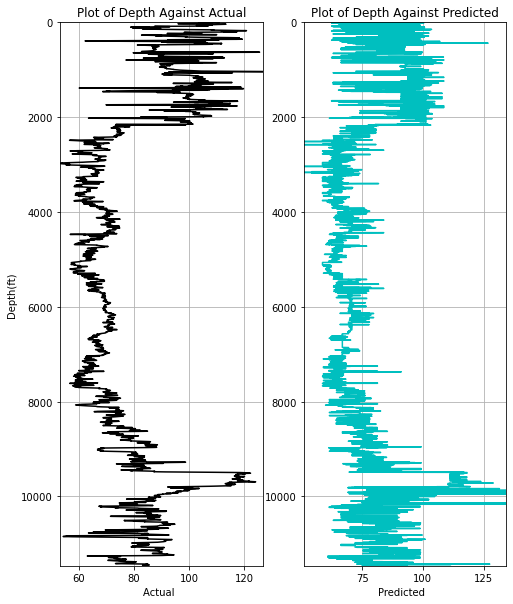

In [23]:
show_plots(f11a, open_pred_dtr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.0s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.2s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.4s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   27.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s remaining:    0.0s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.3s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   26.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.2s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   26.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.9s remaining:    0.0s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.1s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.3s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.1s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.3s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.4s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   28.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.0s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.2s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.4s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.2s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.3s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   26.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.1s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.3s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   26.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   26.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.2s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58

building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   26.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

----------------TEST EVALUATION------------------
RMSE: 4.160570835485179e-05
R1 Score is: 0.9999999999972898
----------------REAL TEST EVALUATION------------------
RMSE: 6.036043339136562
R1 Score is: 0.84930845155746


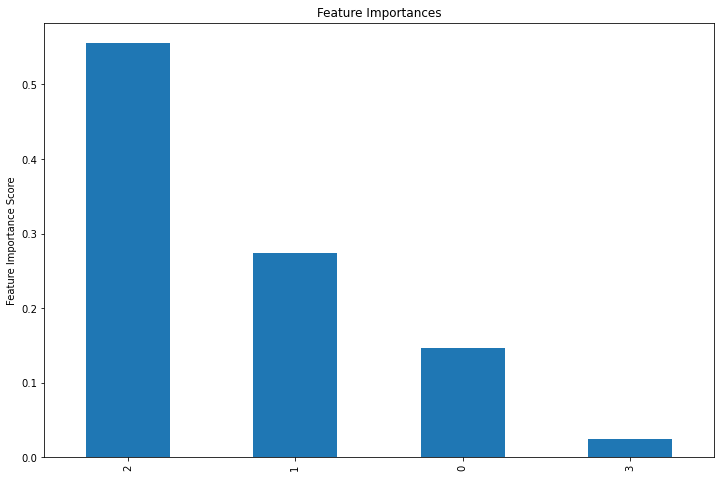

In [26]:
func_= Model('ext', train, test, train_label, test_label)
open_pred_ext, model = func_()
#make_submission(open_pred, filename='CATBOOST1-(UNKNOWN1)')

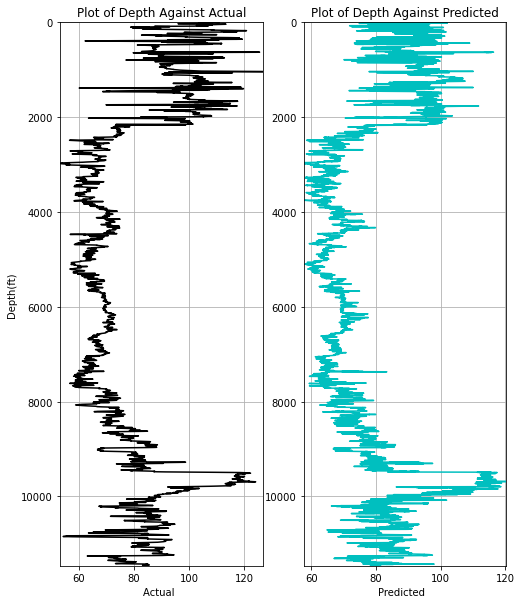

In [27]:
show_plots(f11a, open_pred_ext)

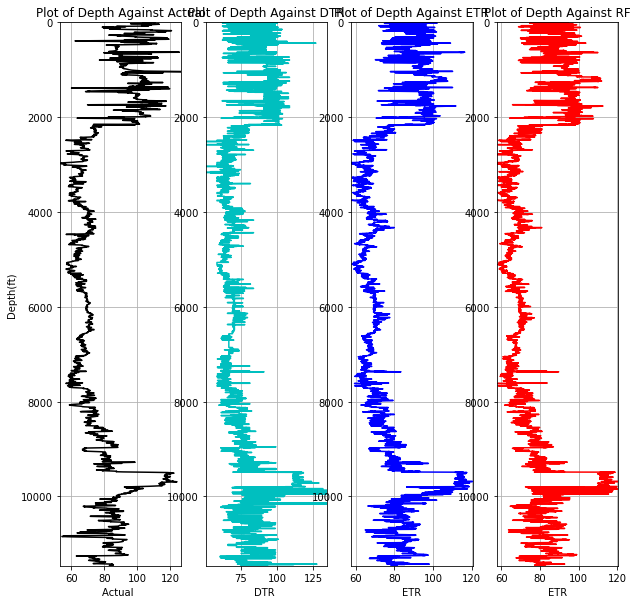

In [28]:
plots = [open_pred_dtr, open_pred_ext, open_pred_rf]

final_plots(f11a, plots)

Training and validation using wel F1

In [12]:
train_label = f1_valid['DT']
test_label = f1['DT']
train = f1_valid.drop('DT', axis=1)
test = f1.drop('DT', axis=1)
train.drop('DEPTH', axis=1, inplace=True)
test.drop('DEPTH', axis=1, inplace=True)
#train.drop('DEPTH.1', axis=1, inplace=True)
test.drop('DEPTH.1', axis=1, inplace=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.2s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.5s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.8s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.1s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.4s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.7s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.0s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.3s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.5s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.3s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.6s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.9s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.2s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.5s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.8s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.1s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.4s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.7s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.3s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.6s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.9s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.2s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.5s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.8s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.1s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.3s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.6s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.1s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.7s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.5s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.8s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.1s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.4s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.1s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.7s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.5s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.8s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.1s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.4s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.1s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.7s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.5s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.8s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.1s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.4s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.1s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.7s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.5s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.8s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.1s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.4s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.2s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.7s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.6s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.8s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.1s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.4s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.1s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.7s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.7s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.1s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.5s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.8s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.1s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.7s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.0s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.5s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.8s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.1s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.4s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

----------------TEST EVALUATION------------------
RMSE: 1.2946088808774427
R1 Score is: 0.9971537784156067
----------------REAL TEST EVALUATION------------------
RMSE: 6.60894042283569
R1 Score is: 0.7436677138969252


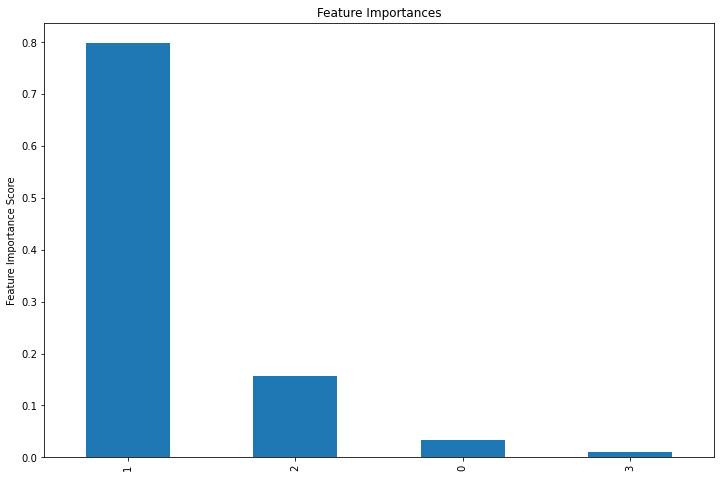

In [25]:
func_= Model('rf', train, test, train_label, test_label)
open_pred_rf, model = func_()

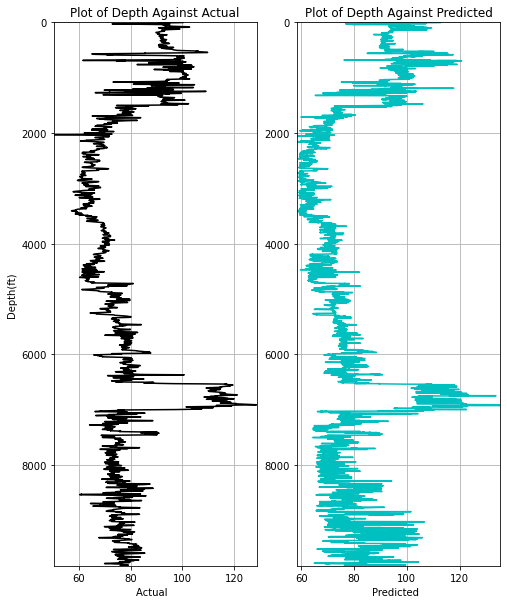

In [26]:
show_plots(f1, open_pred_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.6s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.9s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.2s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.5s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.8s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   56.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   55.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.4s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.7s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   55.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

----------------TEST EVALUATION------------------
RMSE: 2.1927356457030715e-06
R1 Score is: 0.9999999999999918
----------------REAL TEST EVALUATION------------------
RMSE: 6.283106983388931
R1 Score is: 0.7683199991102888


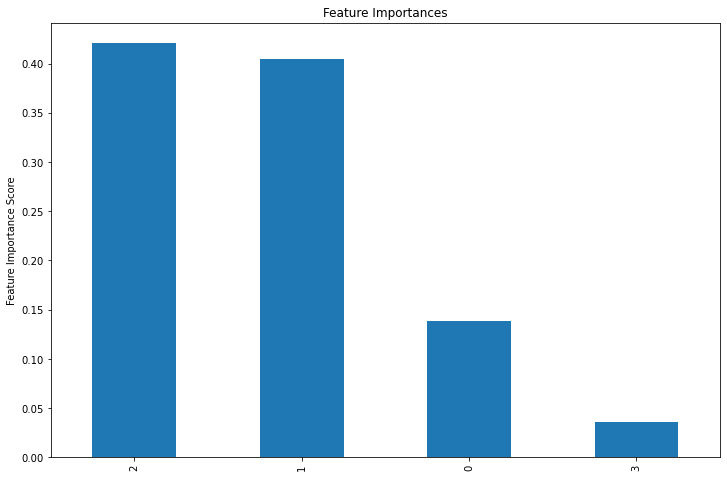

In [20]:
func_= Model('ext', train, test, train_label, test_label)
open_pred, model = func_()

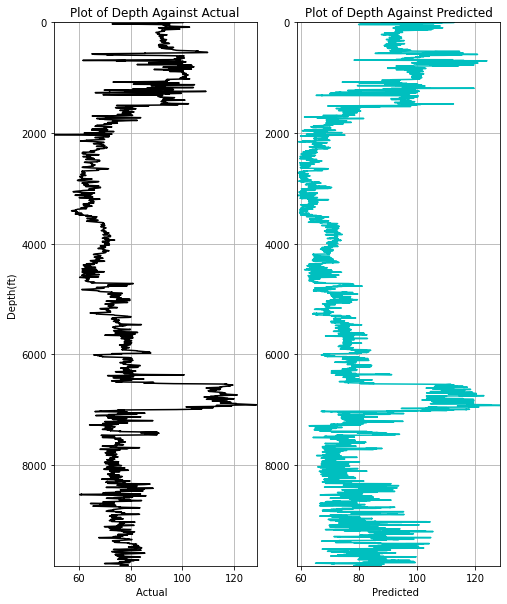

In [24]:
show_plots(f1, open_pred_ext)

In [23]:
open_pred_ext = open_pred

/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: Fut

----------------TEST EVALUATION------------------
RMSE: 1.1479229678298641
R1 Score is: 0.9977622218201335
----------------REAL TEST EVALUATION------------------
RMSE: 8.56538409870701
R1 Score is: 0.5694403545775939


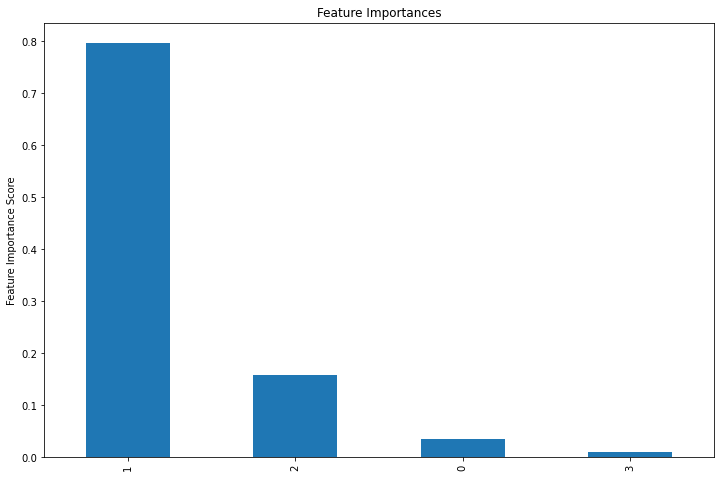

In [17]:
func_= Model('dtr', train, test, train_label, test_label)
open_pred_dtr, model = func_()

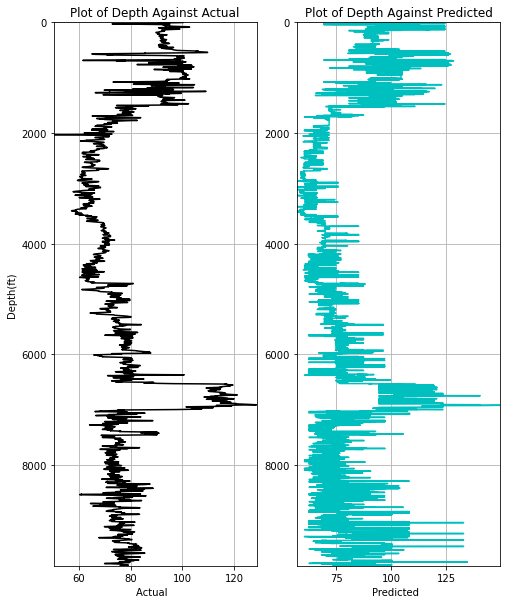

In [19]:
show_plots(f1, open_pred_dtr)

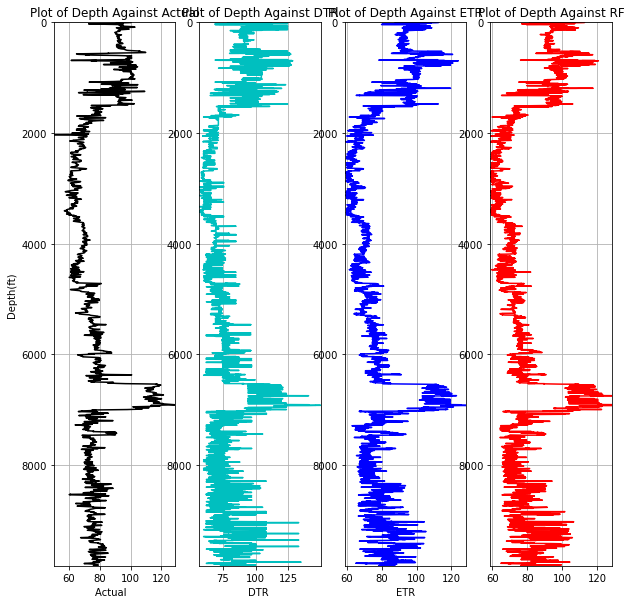

In [27]:
plots = [open_pred_dtr, open_pred_ext, open_pred_rf]
final_plots(f1, plots)

Training and validation using wel FT2

In [11]:
train_label = ft2_valid['DT']
test_label = ft2['DT']
train = ft2_valid.drop('DT', axis=1)
test = ft2.drop('DT', axis=1)
train.drop('DEPTH', axis=1, inplace=True)
test.drop('DEPTH', axis=1, inplace=True)
#train.drop('DEPTH.1', axis=1, inplace=True)
test.drop('DEPTH.1', axis=1, inplace=True)

/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: Fut

----------------TEST EVALUATION------------------
RMSE: 1.0722345789968497
R1 Score is: 0.9941638618538484
----------------REAL TEST EVALUATION------------------
RMSE: 6.833252725998702
R1 Score is: 0.7897089936236334


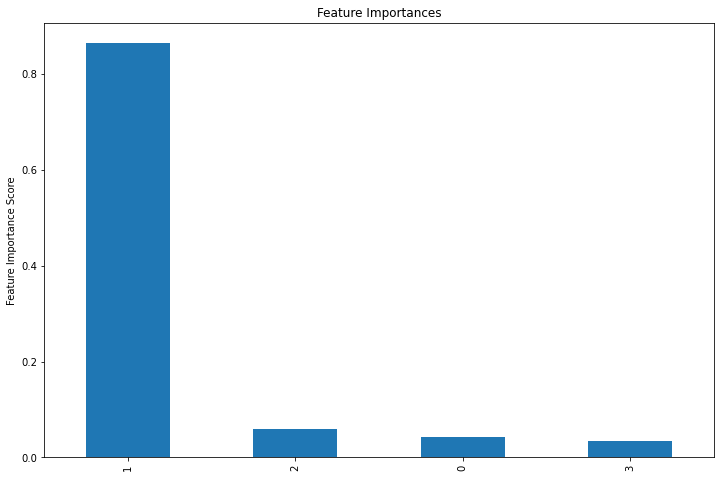

In [12]:
func_= Model('dtr', train, test, train_label, test_label)
open_pred_dtr, model = func_()
#make_submission(open_pred, filename='CATBOOST1-(UNKNOWN1)')

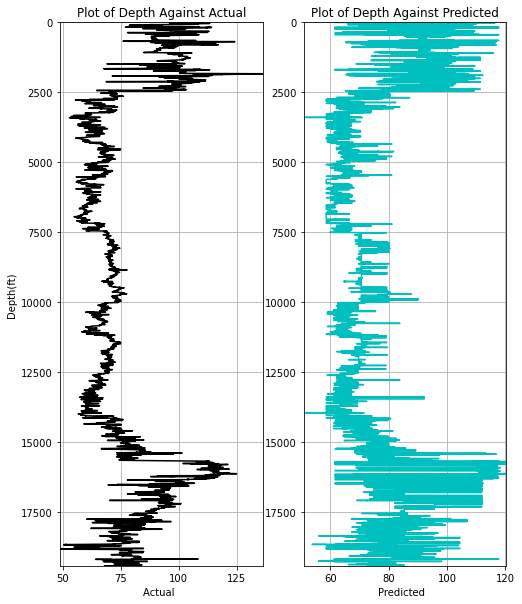

In [14]:
show_plots(ft2, open_pred_dtr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400
building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s


building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.5s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.7s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.9s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.0s remaining:    0.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62

building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   40.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.4s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.7s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   39.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s


building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s remaining:    0.0s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.8s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   40.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.7s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   40.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s


building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.4s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.7s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   40.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400
building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s


building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s


building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.4s remaining:    0.0s


building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.6s remaining:    0.0s


building tree 16 of 400
building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s remaining:    0.0s


building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   40.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.8s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.0s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   41.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.6s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.8s remaining:    0.0s


building tree 18 of 400
building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   40.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400
building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s


building tree 6 of 400
building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s


building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s remaining:    0.0s


building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.4s remaining:    0.0s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.7s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.9s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.1s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   42.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


building tree 4 of 400
building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s


building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s remaining:    0.0s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.7s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   40.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

----------------TEST EVALUATION------------------
RMSE: 1.2587333151024691e-06
R1 Score is: 0.999999999999992
----------------REAL TEST EVALUATION------------------
RMSE: 4.953189334781088
R1 Score is: 0.8895067899008189


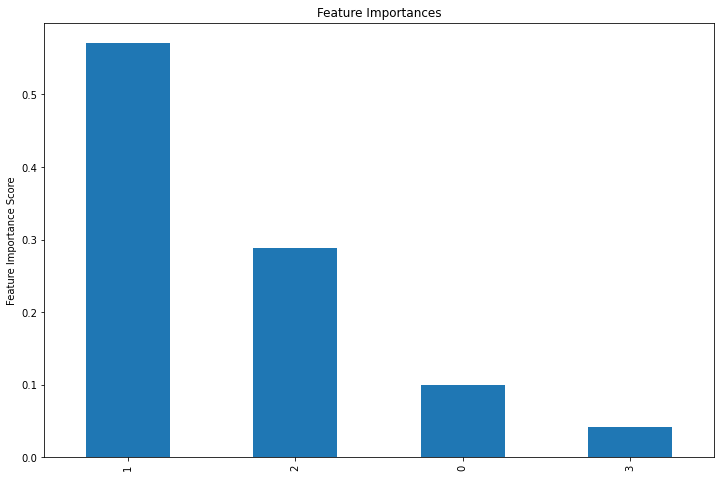

In [15]:
func_= Model('ext', train, test, train_label, test_label)
open_pred_ext, model = func_()
#make_submission(open_pred, filename='CATBOOST1-(UNKNOWN1)')

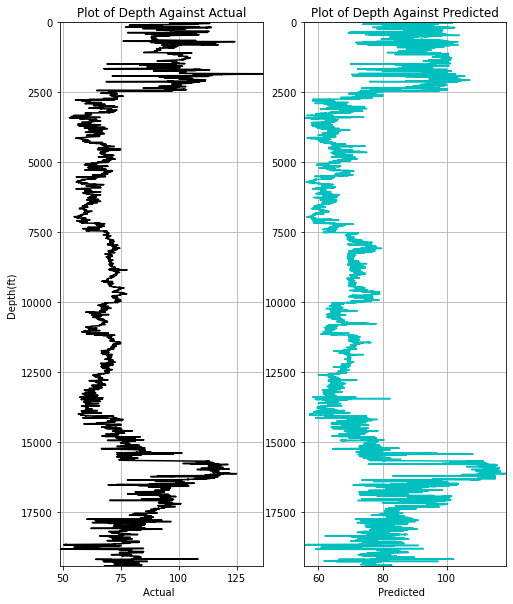

In [16]:
show_plots(ft2, open_pred_ext)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.3s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.8s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.1s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.4s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.6s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.9s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.1s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.4s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.6s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.9s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.7s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.0s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.2s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.5s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.7s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.5s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.8s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.3s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.8s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.1s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.3s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.6s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.8s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.1s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.3s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.6s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.8s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.1s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.4s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.9s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.1s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.4s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.6s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.9s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.1s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.4s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.6s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.9s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.7s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.0s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.2s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.5s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.7s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.5s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.7s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.7s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.0s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.2s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.5s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.7s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.5s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.7s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.7s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.0s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.2s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.5s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.7s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.5s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.7s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.7s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.0s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.2s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.5s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.8s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.3s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.5s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.8s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.7s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.0s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.2s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.5s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.7s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.5s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.7s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.3s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    2.8s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.0s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.2s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    3.5s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.7s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.2s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    4.5s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    4.7s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

----------------TEST EVALUATION------------------
RMSE: 0.764899563130443
R1 Score is: 0.9970300114744586
----------------REAL TEST EVALUATION------------------
RMSE: 5.487016936524003
R1 Score is: 0.8644066676065336


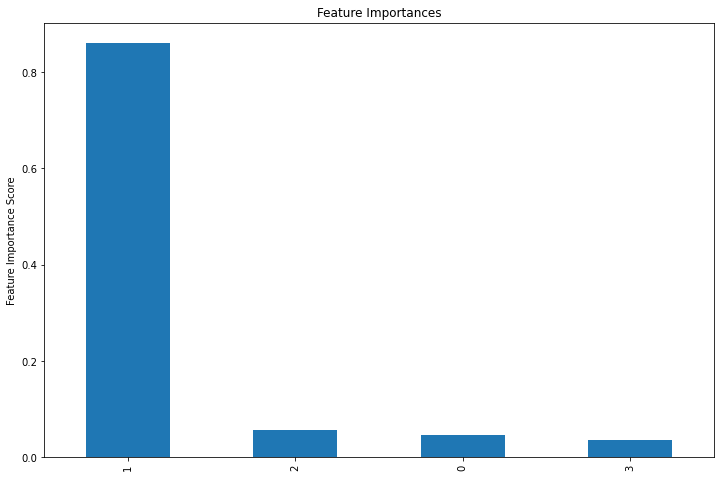

In [17]:
func_= Model('rf', train, test, train_label, test_label)
open_pred_rf, model = func_()
#make_submission(open_pred, filename='CATBOOST1-(UNKNOWN1)')

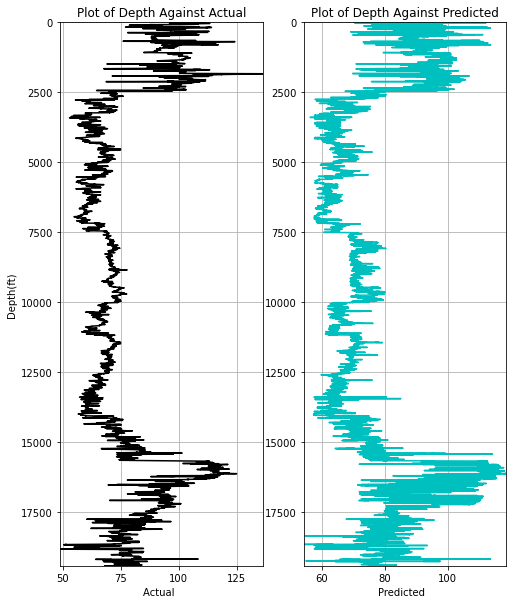

In [18]:
show_plots(ft2, open_pred_rf)

In [ ]:
plots = [open_pred_dtr, open_pred_ext, open_pred_rf]
final_plots(f1, plots)

Training and validation using wel F11A

In [10]:
train_label = f12_valid['DT']
test_label = f12['DT']
train = f12_valid.drop('DT', axis=1)
test = f12.drop('DT', axis=1)
train.drop('DEPTH', axis=1, inplace=True)
test.drop('DEPTH', axis=1, inplace=True)
#train.drop('DEPTH.1', axis=1, inplace=True)
test.drop('DEPTH.1', axis=1, inplace=True)

/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/home/olawale/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: Fut

----------------TEST EVALUATION------------------
RMSE: 1.1891221075475022
R1 Score is: 0.9934192273641355
----------------REAL TEST EVALUATION------------------
RMSE: 26.558008240896083
R1 Score is: 0.09972749798789682


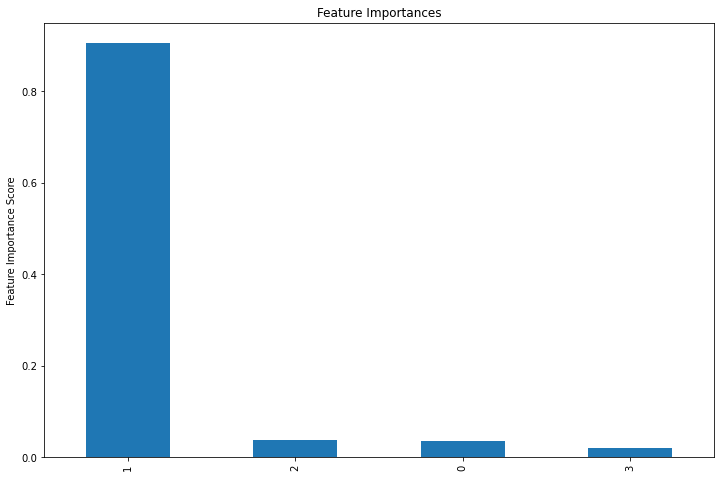

In [11]:
func_= Model('dtr', train, test, train_label, test_label)
open_pred_dtr, model = func_()

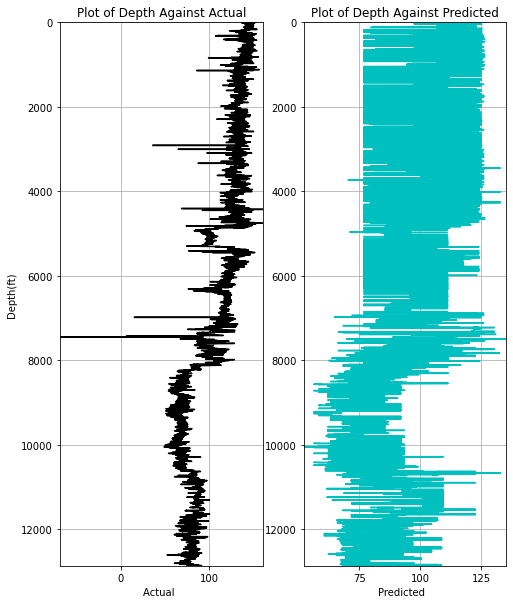

In [12]:
show_plots(f12, open_pred_dtr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.4s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.7s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   57.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.6s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.9s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.2s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.5s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.7s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   56.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   55.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.4s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.7s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   55.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.6s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.9s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.4s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.7s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   55.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   55.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   54.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400
building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 400
building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining:    0.0s


building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.5s remaining:    0.0s


building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.8s remaining:    0.0s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s remaining:    0.0s


building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.3s remaining:    0.0s


building tree 17 of 400
building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s remaining:    0.0s


building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   56.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

----------------TEST EVALUATION------------------
RMSE: 6.20325288107287e-06
R1 Score is: 0.9999999999998209
----------------REAL TEST EVALUATION------------------
RMSE: 20.212220467297445
R1 Score is: 0.4785519640713326


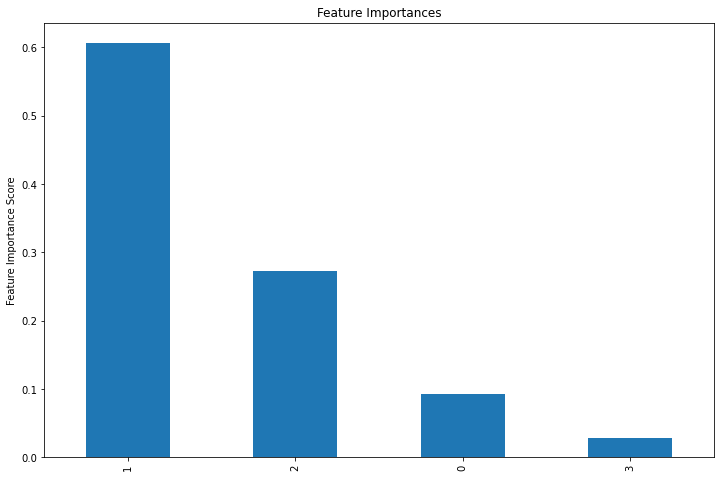

In [13]:
func_= Model('ext', train, test, train_label, test_label)
open_pred_ext, model = func_()

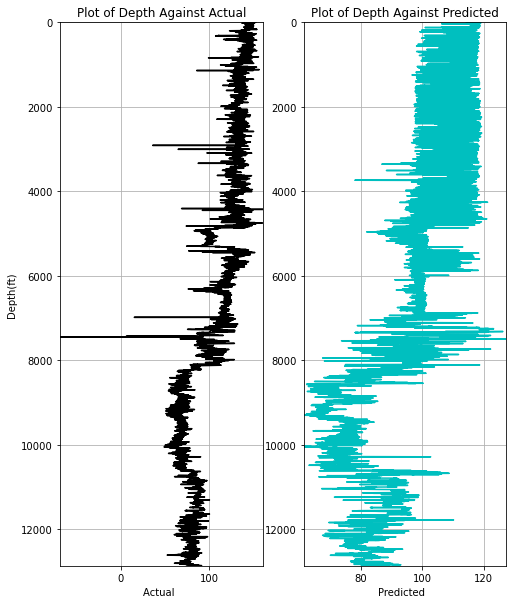

In [14]:
show_plots(f12, open_pred_ext)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.9s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.5s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.9s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.2s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.5s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.8s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    5.1s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.4s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.8s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    6.1s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.2s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.5s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.8s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.1s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.4s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.7s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.0s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.3s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.6s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.2s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.5s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.8s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.1s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.4s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.7s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.0s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.3s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.6s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.2s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.6s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.9s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.1s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.4s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.7s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.0s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.3s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.6s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.3s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.6s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.9s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.2s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.5s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.8s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.2s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.4s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.7s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.2s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.5s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.8s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.1s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.6s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.9s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.2s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.5s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.8s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.4s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.7s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.0s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.3s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.6s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.9s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.2s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.6s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.9s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.3s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.6s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.0s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.3s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.7s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    5.0s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.3s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.6s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.9s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.2s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.5s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.8s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.1s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.4s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.7s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.0s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.3s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.6s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 400


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


building tree 4 of 400


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


building tree 5 of 400


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


building tree 6 of 400


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


building tree 7 of 400


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.1s remaining:    0.0s


building tree 8 of 400


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.4s remaining:    0.0s


building tree 9 of 400


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


building tree 10 of 400


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s


building tree 11 of 400


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.3s remaining:    0.0s


building tree 12 of 400


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.6s remaining:    0.0s


building tree 13 of 400


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.9s remaining:    0.0s


building tree 14 of 400


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.2s remaining:    0.0s


building tree 15 of 400


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.5s remaining:    0.0s


building tree 16 of 400


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.8s remaining:    0.0s


building tree 17 of 400


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.1s remaining:    0.0s


building tree 18 of 400


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.4s remaining:    0.0s


building tree 19 of 400


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.6s remaining:    0.0s


building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

----------------TEST EVALUATION------------------
RMSE: 1.045134103879429
R1 Score is: 0.9949164392424459
----------------REAL TEST EVALUATION------------------
RMSE: 22.543375934160895
R1 Score is: 0.35133436666229745


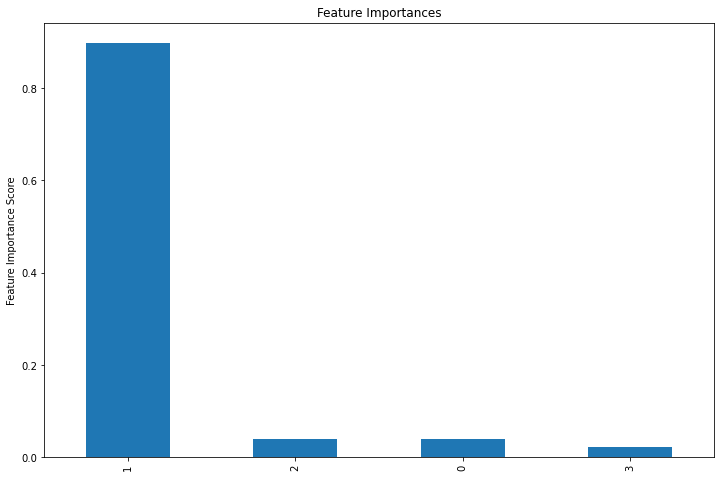

In [15]:
func_= Model('rf', train, test, train_label, test_label)
open_pred_rf, model = func_()

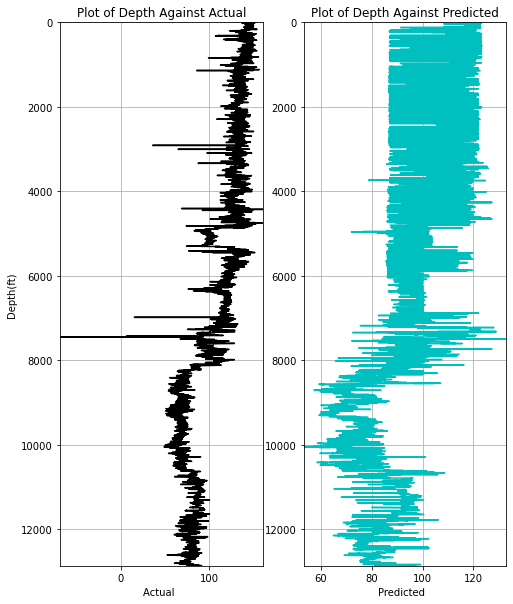

In [16]:
show_plots(f12, open_pred_rf)

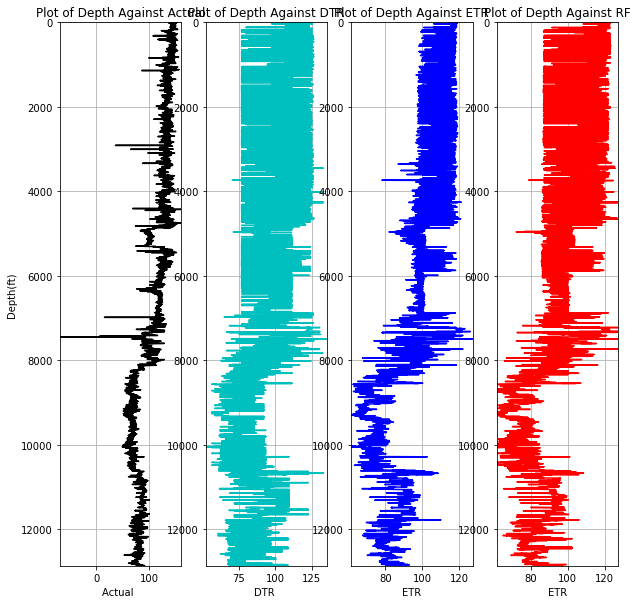

In [18]:
plots = [open_pred_dtr, open_pred_ext, open_pred_rf]
final_plots(f12, plots)